<h1 style="background-color:rgb(67, 77, 86);
           font-size:300%;
           font-style: oblique;
           color:white;
           text-align:center;
           margin: auto;
           padding: 20px;">Predicting Bank Churners</h1>

<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Chapter 4: Scaling</h2>

<a id='1.1'>
    <h2 style='font-size:180%;'>
        Mission</h2></a>

<figure>
    <blockquote cite='https://www.kaggle.com/sakshigoyal7/credit-card-customers/tasks?taskId=2729'>
        <p style='font-size:110%;
                  color:hsl(208, 12%, 30%);'><i>Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as non-churning will do. So recall needs to be higher. Till now, I have managed to get a recall of 62%.</i></p>
    </blockquote>
    <figcaption>—Sakshi Goyal, <cite>Credit Card Customers, Kaggle</cite></figcaption>

<a id='4'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Initial Preparation
    </h2>
</a>

<a id='4.1'>
    <h2 style='font-size:210%;'>
        Libraries
    </h2>
</a>

In [ ]:
global_built_ins = dir() + ['global_built_ins']

In [2]:
# general
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import statsmodels.api as sm

# statistics
from numpy import (mean, std)

# machine learning prep
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer)
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_predict,
    RepeatedStratifiedKFold)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score, 
    confusion_matrix, make_scorer, SCORERS)
from imblearn.pipeline import Pipeline
# from sklearn.pipeline import Pipeline

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import (SVC, LinearSVC) # remove SVC later if not used
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, 
    GradientBoostingClassifier, IsolationForest)
from sklearn.neural_network import MLPClassifier

# warning
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

# saving
import os

# efficiency
import time

# Display Settings

In [3]:
# display settings
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(suppress=True, precision=3)

In [4]:
%%html
<style>
/* CSS styles for pandas dataframe */
.dataframe th {
    font-size: 16px;
}
.dataframe td {
    font-size: 14px;
}
</style>

In [5]:
global_libraries = [i for i in dir() if i not in global_built_ins] + ['global_libraries']

In [6]:
global_keep_native = global_built_ins + global_libraries

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Data Loading & Processing
    </h2>
</a>

In [7]:
time_start = time.time()

In [8]:
# load data
d = pd.read_csv('source/d_num.csv')
d.head(3)

,churn,age,gender,dependents,prod_ct,mo_on_book,mo_inactive_r12,contr_ct_r12,revbal_avg_r12,credlim_avg_r12,opentobuy_avg_r12,utilratio_avg,tx_amt_r12,tx_ct_r12,chng_tx_amt_q4_q1,chng_tx_ct_q4_q1,marstat_Divorced,marstat_Married,marstat_Single,marstat_Unknown,card_Blue,card_Gold,card_Platinum,card_Silver,educ,inc,tx_amt_pertx_r12
0,0,45,1,3,5,39,1,3,777.00,"12,691.00","11,914.00",0.06,"1,144.00",42,1.33,1.62,0,1,0,0,1,0,0,0,1,3,27.24
1,0,49,0,5,6,44,1,2,864.00,"8,256.00","7,392.00",0.10,"1,291.00",33,1.54,3.71,0,0,1,0,1,0,0,0,3,1,39.12
2,0,51,1,3,4,36,1,0,0.00,"3,418.00","3,418.00",0.00,"1,887.00",20,2.59,2.33,0,1,0,0,1,0,0,0,3,4,94.35


In [9]:
d = d.values
x, y = d[:,1:], d[:,:1].ravel()

<a id='6.1'>
    <h2 style='font-size:210%;'>
        Functions
    </h2>
</a>

<a id='6.1'>
    <h2 style='font-size:180%;'>
        Results with Repeated Stratified K-Fold
    </h2>
</a>

In [10]:
def result_rskf(x, y, pipeline, mod_disp_name, n_splits=5, n_repeats=3):
   
    # define cv method
    cv = RepeatedStratifiedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=1)  
    
    # evaluate result
    scoring = {
        'accuracy':'accuracy', 'precision':'precision', 'recall':'recall', 'f1':'f1', 
        'f2':make_scorer(fbeta_score, beta=2)} # dict val = scorer fct or predefined metric str  
    result = cross_validate(
        pipeline, x, y, cv=cv, 
        scoring=scoring, return_train_score=True, n_jobs=-1)
        
    # make a summary table
    df = pd.DataFrame(
        (k, mean(v), std(v)) for k,v in result.items()
        ).rename({0:'metric', 1:'mean', 2:'std'}, axis=1
                ).set_index('metric')
    df.index.name = None
    df.columns = pd.MultiIndex.from_product([[mod_disp_name],df.columns])
    
    return df, result

<a id='6.1'>
    <h2 style='font-size:180%;'>
        Results with Train Test Split
    </h2>
</a>

In [11]:
def result_tts(x, y, pipeline, mod_disp_name):
    
    # define cv method
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)
    
    # evaluate result   
    time_0 = time()
    pipeline.fit(x_train, y_train)
    time_1 = time()
    y_pred = pipeline.predict(x_test)
    time_2 = time()
    result = {}
    result['fit_time'] = round(time_1-time_0, 2)
    result['score_time'] = round(time_2-time_1, 2)
    result['accuracy'] = round(accuracy_score(y_test, y_pred), 2)
    result['precision'] = round(precision_score(y_test, y_pred), 2)
    result['recall'] = round(recall_score(y_test, y_pred), 2)
    result['f1'] = round(f1_score(y_test, y_pred), 2)
    result['f2'] = round(fbeta_score(y_test, y_pred, beta=2), 2)
    conf_mat = confusion_matrix(y_test, y_pred, labels=[1,0])
    
    # make a summary table    
    df = pd.DataFrame(result, index=[mod_disp_name]).T
    
    return df, result, conf_mat, y_pred, y_test

<a id='6.1'>
    <h2 style='font-size:180%;'>
        Results with Treatment - Scaler
    </h2>
</a>

In [12]:
def summary_by_mod(models, scalers, result_func=result_rskf, **n_splits_and_repeats):
    results = []
    time_0 = time.time() # for all methods in pipeline
    for scaler in scalers:
        results_models = []
        time_1 = time.time() # for each scaler
        print(f'Scaler: {scaler[0]}\n')
        for model in models:
            time_2 = time.time() # for each model
            pipeline = Pipeline([('s', scaler[1]), ('m', model[1])])
            if result_func==result_rskf:
                n_splits, n_repeats = (i for i in n_splits_and_repeats.values())
                results_model = result_func(x, y, pipeline, model[0], n_splits, n_repeats)[0]
            else:
                results_model = result_func(x, y, pipeline, model[0])[0]
            print(f'Model {model[0]} Runtime: {time.strftime("%M:%S", time.gmtime(time.time()-time_2))}')
            results_models.append(results_model)
        print(f'Scaler {scaler[0]} Avg Runtime per Model: {time.strftime("%M:%S", time.gmtime((time.time()-time_1)/len(models)))}\n\n')
        results.append(results_models)
    print(f'Total Runtime: {time.strftime("%M:%S", time.gmtime(time.time()-time_0))} min')
    return results

<a id='6.1'>
    <h2 style='font-size:180%;'>
        Results in Plots
    </h2>
</a>

In [13]:
# Work in Progress
# def plot_results(df):
    
#     # prepare df for plotting
#     df_plot = df[[df.columns[i] for i in range(0, len(df.columns), 2)]]
#     df_plot.columns = df_plot.columns.droplevel(1)
    
#     # configure settings
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     plt.figure(figsize=(10,6))
#     fig.suptitle('Comparisons of Model Performance')
    
#     # plot by model
#     df_plot_mod = df_plot.iloc[[i for i in range(2,len(df_plot),2)],:]
#     ax1.plot(df_plot_mod)
#     ax1.suptitle('by Model')
#     plt.show()  
    
#     # plot by metric
#     df_plot_metric = df_plot.T.iloc[:,[i for i in range(2,len(df_plot),2)]]
#     ax2.plot(df_plot_metric)
#     ax2.suptitle('by Metric')
#     plt.show()
    
#     return df_plot_mod, df_plot_metric

In [14]:
def plot_results(df):
    
    # prepare df for plotting
    df_plot = df[[df.columns[i] for i in range(0, len(df.columns), 2)]]
    df_plot.columns = df_plot.columns.droplevel(1)
    
    # plot by model
    df_plot_mod = df_plot.iloc[[i for i in range(2,len(df_plot),2)],:]
    df_plot_mod.plot(figsize=(10,6), title='Comparisons by Model')
    plt.show()  
    
    # plot by metric
    df_plot_metric = df_plot.T.iloc[:,[i for i in range(2,len(df_plot),2)]]
    df_plot_metric.plot(figsize=(10,6), title='Comparisons by Metric')
    plt.show()
    
    return df_plot_mod, df_plot_metric

In [15]:
def plot_results_df(df):
    df_plot = df[[df.columns[i] for i in range(0, len(df.columns), 2)]]
    df_plot.columns = df_plot.columns.droplevel(1)
    df_plot_mod = df_plot.iloc[[i for i in range(2,len(df_plot),2)],:]
    return df_plot_mod

<a id='5'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Normality Test Recap
    </h2>
</a>

From the previous chapter we concluded that it might be beneficial to standardize `age`, `mo_on_book`, `contr_ct_r12`, and `tx_ct_r12` but normalize all other variables in the feature transformation section before feature selection. Let us see the effects of different scalers on each of the algorithms.

<a id='6'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Model & Scaler Selection
    </h2>
</a>

<a id='6.2'>
    <h2 style='font-size:210%;'>
        Models
    </h2>
</a>

In [16]:
# create a list of tuples for all models to explore: [(`model name`, `model instance`)] with minimum hyperparameter setting
models = []

# linear
models.append(('LR', LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', random_state=5))) # note: `max_iter` from 1000 to 10000 due to convergence issues
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))

# non-linear
models.append(('DT', DecisionTreeClassifier(random_state=5)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('MLP', MLPClassifier(max_iter=1000, random_state=5)))

# ensemble
models.append(('BDT', BaggingClassifier(n_estimators=50, n_jobs=-1, random_state=5)))
models.append(('RF', RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=5))) # note: increasing n_estimators more than 400 doesn't do much; some in place to prevent too much overfitting
models.append(('GB', GradientBoostingClassifier(random_state=5))) # note: `max_iter` from 100 to 1000 due to convergence issues

<a id='6.2'>
    <h2 style='font-size:210%;'>
        Scalers
    </h2>
</a>

In [17]:
# create a list of tuples for all scalers to explore: [(`scaler name`, `scaler instance`)]
scalers = []
scalers.append(('SS', StandardScaler()))
scalers.append(('MM', MinMaxScaler()))
scalers.append(('RS', RobustScaler()))
scalers.append(('QT', QuantileTransformer()))
scalers.append(('PT', PowerTransformer()))

<a id='6'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Baseline Models
    </h2>
</a>

Below is a summary of our baseline performance without the scalers. We can see the pattern that linear models that make strong assumptions of the functional form did significantly worse than the rule-following tree methods. MLP, for instance, requires data to be scaled to ensure convergence. We can expect to see significant improvement in the performance of these linear models after the scaling procedure.

<a id='6.2.1'>
    <h2 style='font-size:180%;'>
        No Scaler
    </h2>
</a>

In [18]:
time_0 = time.time() # total fit time
results_bsl = []
for model in models:
    time_1 = time.time() # for each model
    pipeline = Pipeline([('m', model[1])])
    results_model = result_rskf(x, y, pipeline, model[0], n_splits=5, n_repeats=3)[0]
    print(f'Model {model[0]} Runtime: {time.strftime("%M:%S", time.gmtime(time.time()-time_1))}')
    results_bsl.append(results_model)
print(f'Total Runtime: {time.strftime("%M:%S", time.gmtime(time.time()-time_0))} min')

Model LR Runtime: 00:25
Model LDA Runtime: 00:00
Model NB Runtime: 00:00
Model DT Runtime: 00:00
Model KNN Runtime: 00:21
Model MLP Runtime: 00:08
Model BDT Runtime: 00:18
Model RF Runtime: 00:04
Model GB Runtime: 00:15
Total Runtime: 01:34 min


In [19]:
results_bsl_NS = pd.concat((i for i in results_bsl), axis=1)

In [20]:
results_bsl_NS

LR       LDA        NB        DT       KNN       MLP       \
                mean  std mean  std mean  std mean  std mean  std mean  std   
fit_time        9.79 0.08 0.10 0.00 0.02 0.00 0.24 0.02 0.01 0.00 3.42 0.76   
score_time      0.03 0.01 0.02 0.00 0.02 0.00 0.02 0.01 1.68 0.17 0.03 0.01   
test_accuracy   0.77 0.01 0.91 0.00 0.90 0.00 0.94 0.00 0.89 0.00 0.87 0.02   
train_accuracy  0.77 0.00 0.91 0.00 0.90 0.00 1.00 0.00 0.92 0.00 0.87 0.02   
test_precision  0.39 0.02 0.78 0.02 0.71 0.02 0.81 0.01 0.70 0.01 0.69 0.13   
train_precision 0.39 0.00 0.78 0.00 0.71 0.01 1.00 0.00 0.80 0.01 0.70 0.13   
test_recall     0.75 0.01 0.64 0.02 0.62 0.02 0.81 0.02 0.57 0.03 0.45 0.22   
train_recall    0.75 0.00 0.64 0.00 0.62 0.01 1.00 0.00 0.67 0.01 0.46 0.23   
test_f1         0.52 0.02 0.70 0.01 0.66 0.01 0.81 0.01 0.63 0.02 0.49 0.14   
train_f1        0.52 0.00 0.70 0.00 0.66 0.00 1.00 0.00 0.73 0.00 0.50 0.14   
test_f2         0.63 0.01 0.66 0.02 0.63 0.02 0.81 0.02 0.59 0.02 0.46 0.19   
train_f2        0.64 0.00 0.66 0.00 0.63 0.00 1.00 0.00 0.69 0.01 0.47 0.19   

                 BDT        RF        GB       
                mean  std mean  std mean  std  
fit_time        7.42 0.90 1.51 0.29 7.33 0.26  
score_time      0.95 1.00 0.27 0.19 0.03 0.01  
test_accuracy   0.96 0.00 0.96 0.00 0.97 0.00  
train_accuracy  1.00 0.00 0.99 0.00 0.98 0.00  
test_precision  0.91 0.01 0.93 0.01 0.93 0.01  
train_precision 1.00 0.00 0.99 0.00 0.96 0.00  
test_recall     0.85 0.02 0.81 0.02 0.85 0.02  
train_recall    1.00 0.00 0.93 0.00 0.89 0.00  
test_f1         0.88 0.01 0.86 0.02 0.89 0.01  
train_f1        1.00 0.00 0.96 0.00 0.92 0.00  
test_f2         0.86 0.02 0.83 0.02 0.86 0.02  
train_f2        1.00 0.00 0.94 0.00 0.90 0.00

In [22]:
results_bsl_NS_plot_df = plot_results_df(results_bsl_NS)

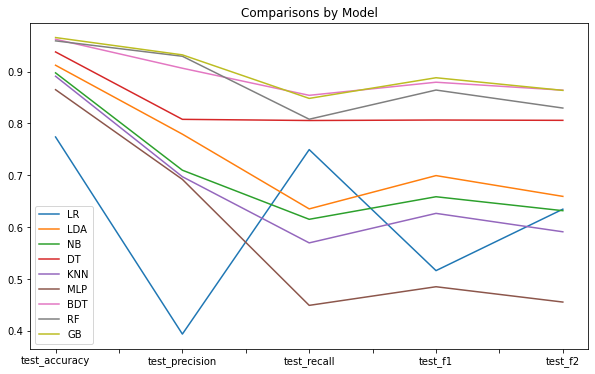

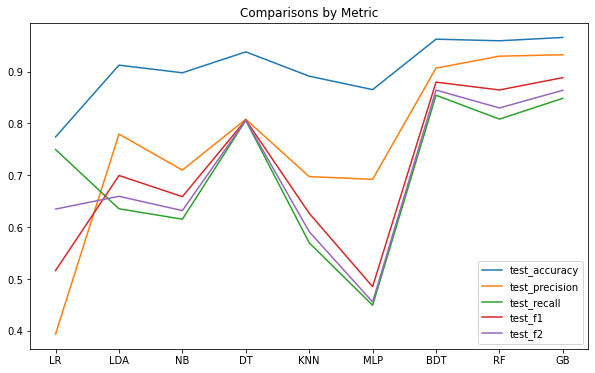

In [23]:
results_bsl_NS_plot = plot_results(results_bsl_NS)

<a id='6'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Treatment Models
    </h2>
</a>

In [24]:
results_trmt = summary_by_mod(models, scalers, result_func=result_rskf, n_splits=5, n_repeats=3)

Scaler: SS

Model LR Runtime: 00:04
Model LDA Runtime: 00:00
Model NB Runtime: 00:00
Model DT Runtime: 00:00
Model KNN Runtime: 00:21
Model MLP Runtime: 04:27
Model BDT Runtime: 00:16
Model RF Runtime: 00:04
Model GB Runtime: 00:18
Scaler SS Avg Runtime per Model: 00:37


Scaler: MM

Model LR Runtime: 00:02
Model LDA Runtime: 00:00
Model NB Runtime: 00:00
Model DT Runtime: 00:01
Model KNN Runtime: 00:25
Model MLP Runtime: 02:46
Model BDT Runtime: 00:17
Model RF Runtime: 00:06
Model GB Runtime: 00:27
Scaler MM Avg Runtime per Model: 00:27


Scaler: RS

Model LR Runtime: 00:22
Model LDA Runtime: 00:00
Model NB Runtime: 00:00
Model DT Runtime: 00:01
Model KNN Runtime: 00:33
Model MLP Runtime: 04:07
Model BDT Runtime: 00:23
Model RF Runtime: 00:06
Model GB Runtime: 00:31
Scaler RS Avg Runtime per Model: 00:40


Scaler: QT

Model LR Runtime: 00:03
Model LDA Runtime: 00:01
Model NB Runtime: 00:02
Model DT Runtime: 00:02
Model KNN Runtime: 00:22
Model MLP Runtime: 03:31
Model BDT Runtime: 00:

In [25]:
results_trmt_SS = pd.concat([i for i in results_trmt[0]], axis=1)
results_trmt_MM = pd.concat([i for i in results_trmt[1]], axis=1)
results_trmt_RS = pd.concat([i for i in results_trmt[2]], axis=1)
results_trmt_QT = pd.concat([i for i in results_trmt[3]], axis=1)
results_trmt_PT = pd.concat([i for i in results_trmt[4]], axis=1)

<a id='6.2.1'>
    <h2 style='font-size:180%;'>
        Standard Scaler
    </h2>
</a>

In [26]:
results_trmt_SS

LR       LDA        NB        DT       KNN         MLP  \
                mean  std mean  std mean  std mean  std mean  std   mean   
fit_time        1.81 0.22 0.11 0.01 0.04 0.00 0.25 0.03 0.05 0.02 133.00   
score_time      0.02 0.00 0.02 0.00 0.02 0.00 0.02 0.00 1.73 0.28   0.05   
test_accuracy   0.86 0.01 0.91 0.00 0.89 0.01 0.94 0.00 0.91 0.00   0.94   
train_accuracy  0.86 0.00 0.91 0.00 0.89 0.00 1.00 0.00 0.93 0.00   1.00   
test_precision  0.54 0.01 0.78 0.02 0.68 0.04 0.81 0.02 0.84 0.02   0.83   
train_precision 0.54 0.00 0.78 0.00 0.68 0.02 1.00 0.00 0.91 0.01   1.00   
test_recall     0.86 0.02 0.64 0.02 0.60 0.03 0.81 0.02 0.54 0.02   0.80   
train_recall    0.87 0.00 0.64 0.00 0.61 0.02 1.00 0.00 0.66 0.01   1.00   
test_f1         0.67 0.01 0.70 0.01 0.64 0.02 0.81 0.01 0.66 0.02   0.81   
train_f1        0.67 0.00 0.70 0.00 0.65 0.01 1.00 0.00 0.76 0.01   1.00   
test_f2         0.77 0.01 0.66 0.02 0.62 0.02 0.81 0.02 0.58 0.02   0.80   
train_f2        0.77 0.00 0.66 0.00 0.63 0.01 1.00 0.00 0.70 0.01   1.00   

                       BDT        RF        GB       
                  std mean  std mean  std mean  std  
fit_time        21.23 7.09 0.76 1.64 0.35 8.68 0.61  
score_time       0.02 0.92 0.86 0.38 0.34 0.04 0.00  
test_accuracy    0.01 0.96 0.00 0.96 0.00 0.97 0.00  
train_accuracy   0.00 1.00 0.00 0.99 0.00 0.98 0.00  
test_precision   0.02 0.91 0.01 0.93 0.01 0.93 0.01  
train_precision  0.00 1.00 0.00 0.99 0.00 0.96 0.00  
test_recall      0.02 0.85 0.02 0.81 0.02 0.85 0.02  
train_recall     0.00 1.00 0.00 0.93 0.00 0.89 0.00  
test_f1          0.02 0.88 0.02 0.86 0.02 0.89 0.01  
train_f1         0.00 1.00 0.00 0.96 0.00 0.92 0.00  
test_f2          0.02 0.86 0.02 0.83 0.02 0.86 0.02  
train_f2         0.00 1.00 0.00 0.94 0.00 0.90 0.00

In [27]:
results_trmt_SS_plot_df = plot_results_df(results_trmt_SS)

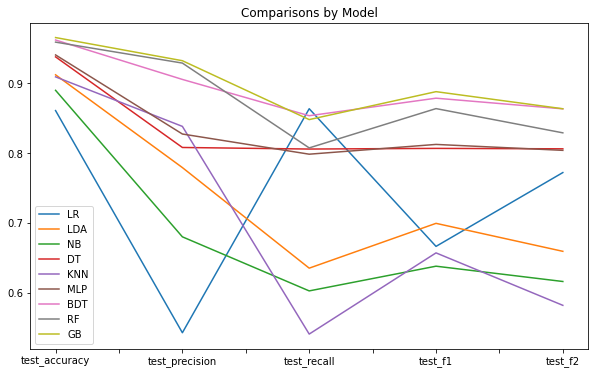

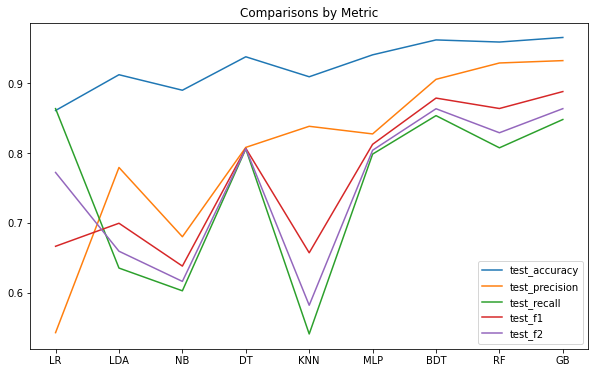

In [28]:
results_trmt_SS_plot = plot_results(results_trmt_SS)

<a id='6.2.2'>
    <h2 style='font-size:180%;'>
        Min Max Scaler
    </h2>
</a>

In [29]:
results_trmt_MM

LR       LDA        NB        DT       KNN        MLP        \
                mean  std mean  std mean  std mean  std mean  std  mean   std   
fit_time        0.81 0.19 0.13 0.01 0.04 0.01 0.38 0.08 0.03 0.02 78.19 18.35   
score_time      0.03 0.01 0.03 0.00 0.03 0.01 0.04 0.01 2.27 0.52  0.03  0.02   
test_accuracy   0.86 0.01 0.91 0.00 0.89 0.01 0.94 0.00 0.89 0.00  0.94  0.01   
train_accuracy  0.86 0.00 0.91 0.00 0.89 0.00 1.00 0.00 0.92 0.00  0.97  0.00   
test_precision  0.54 0.01 0.78 0.02 0.68 0.04 0.81 0.01 0.78 0.03  0.86  0.03   
train_precision 0.54 0.00 0.78 0.00 0.68 0.02 1.00 0.00 0.88 0.01  0.93  0.02   
test_recall     0.86 0.02 0.64 0.02 0.60 0.03 0.81 0.02 0.45 0.03  0.78  0.03   
train_recall    0.87 0.00 0.64 0.00 0.61 0.02 1.00 0.00 0.57 0.01  0.86  0.02   
test_f1         0.66 0.01 0.70 0.01 0.64 0.02 0.81 0.01 0.57 0.02  0.82  0.02   
train_f1        0.66 0.00 0.70 0.00 0.65 0.01 1.00 0.00 0.69 0.01  0.90  0.01   
test_f2         0.77 0.01 0.66 0.02 0.62 0.02 0.81 0.02 0.49 0.03  0.80  0.03   
train_f2        0.77 0.00 0.66 0.00 0.63 0.01 1.00 0.00 0.62 0.01  0.88  0.02   

                 BDT        RF         GB       
                mean  std mean  std  mean  std  
fit_time        7.36 0.82 2.18 0.53 13.16 0.31  
score_time      1.02 1.05 0.59 0.26  0.06 0.03  
test_accuracy   0.96 0.00 0.96 0.00  0.97 0.00  
train_accuracy  1.00 0.00 0.99 0.00  0.98 0.00  
test_precision  0.91 0.01 0.93 0.01  0.93 0.01  
train_precision 1.00 0.00 0.99 0.00  0.96 0.00  
test_recall     0.85 0.02 0.81 0.02  0.85 0.02  
train_recall    1.00 0.00 0.93 0.00  0.89 0.00  
test_f1         0.88 0.01 0.86 0.02  0.89 0.01  
train_f1        1.00 0.00 0.96 0.00  0.92 0.00  
test_f2         0.86 0.02 0.83 0.02  0.86 0.02  
train_f2        1.00 0.00 0.94 0.00  0.90 0.00

In [30]:
results_trmt_MM_plot_df = plot_results_df(results_trmt_MM)

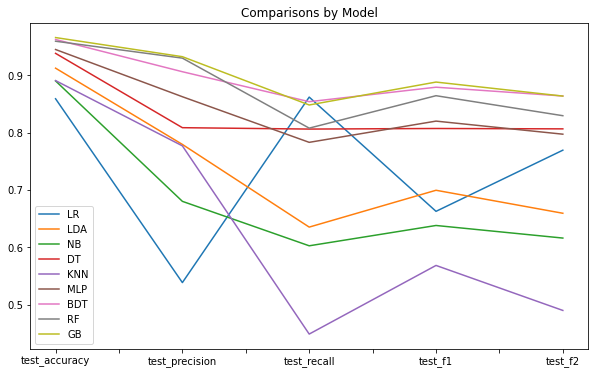

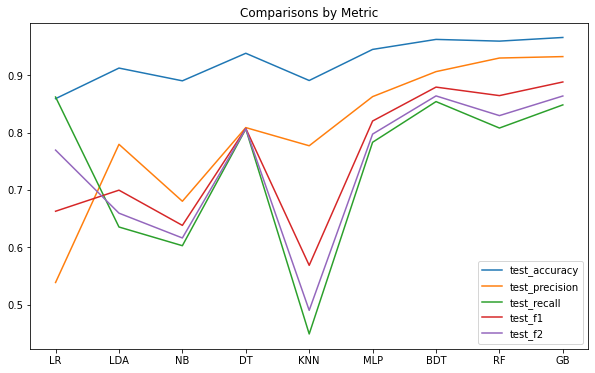

In [31]:
results_trmt_MM_plot = plot_results(results_trmt_MM)

<a id='6.2.3'>
    <h2 style='font-size:180%;'>
        Robust Scaler
    </h2>
</a>

In [32]:
results_trmt_RS

LR       LDA        NB        DT       KNN         MLP  \
                 mean  std mean  std mean  std mean  std mean  std   mean   
fit_time        10.40 1.26 0.22 0.03 0.08 0.00 0.38 0.11 0.10 0.04 121.81   
score_time       0.06 0.02 0.03 0.00 0.03 0.00 0.03 0.01 2.88 0.59   0.04   
test_accuracy    0.86 0.01 0.91 0.00 0.89 0.01 0.94 0.00 0.93 0.00   0.95   
train_accuracy   0.86 0.00 0.91 0.00 0.89 0.00 1.00 0.00 0.95 0.00   1.00   
test_precision   0.54 0.01 0.78 0.02 0.68 0.04 0.81 0.02 0.87 0.02   0.85   
train_precision  0.54 0.00 0.78 0.00 0.68 0.02 1.00 0.00 0.92 0.01   1.00   
test_recall      0.86 0.02 0.64 0.02 0.60 0.03 0.81 0.02 0.64 0.02   0.82   
train_recall     0.87 0.00 0.64 0.00 0.61 0.02 1.00 0.00 0.74 0.01   1.00   
test_f1          0.67 0.01 0.70 0.01 0.64 0.02 0.81 0.01 0.74 0.01   0.84   
train_f1         0.67 0.00 0.70 0.00 0.65 0.01 1.00 0.00 0.82 0.01   1.00   
test_f2          0.77 0.01 0.66 0.02 0.62 0.02 0.81 0.02 0.67 0.02   0.83   
train_f2         0.77 0.00 0.66 0.00 0.63 0.01 1.00 0.00 0.77 0.01   1.00   

                       BDT        RF         GB       
                  std mean  std mean  std  mean  std  
fit_time        23.14 7.76 1.68 2.53 0.75 15.16 1.46  
score_time       0.02 1.55 1.03 0.25 0.17  0.06 0.02  
test_accuracy    0.01 0.96 0.00 0.96 0.00  0.97 0.00  
train_accuracy   0.00 1.00 0.00 0.99 0.00  0.98 0.00  
test_precision   0.03 0.91 0.01 0.93 0.01  0.93 0.01  
train_precision  0.00 1.00 0.00 0.99 0.00  0.96 0.00  
test_recall      0.02 0.85 0.02 0.81 0.02  0.85 0.02  
train_recall     0.00 1.00 0.00 0.93 0.00  0.89 0.00  
test_f1          0.02 0.88 0.01 0.86 0.01  0.89 0.01  
train_f1         0.00 1.00 0.00 0.96 0.00  0.92 0.00  
test_f2          0.02 0.86 0.02 0.83 0.02  0.86 0.02  
train_f2         0.00 1.00 0.00 0.94 0.00  0.90 0.00

In [33]:
results_trmt_RS_plot_df = plot_results_df(results_trmt_RS)

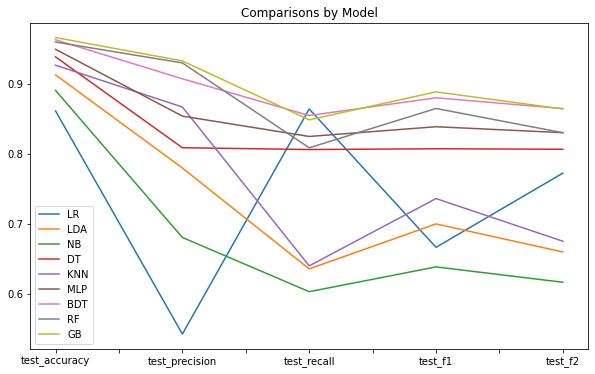

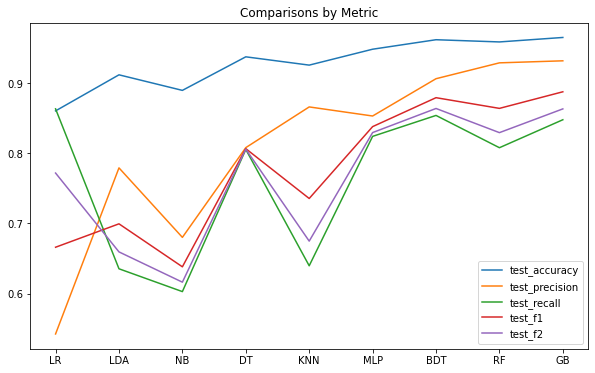

In [34]:
results_trmt_RS_plot = plot_results(results_trmt_RS)

<a id='6.2.4'>
    <h2 style='font-size:180%;'>
        Quantile Transformer
    </h2>
</a>

In [35]:
results_trmt_QT

LR       LDA        NB        DT       KNN         MLP  \
                mean  std mean  std mean  std mean  std mean  std   mean   
fit_time        1.45 0.18 0.48 0.07 0.51 0.15 0.85 0.32 0.29 0.05 102.18   
score_time      0.08 0.02 0.10 0.02 0.18 0.10 0.09 0.02 2.22 0.23   0.08   
test_accuracy   0.85 0.01 0.91 0.00 0.88 0.01 0.94 0.00 0.90 0.00   0.95   
train_accuracy  0.86 0.00 0.91 0.00 0.88 0.00 1.00 0.00 0.93 0.00   0.98   
test_precision  0.53 0.01 0.77 0.01 0.63 0.03 0.81 0.02 0.81 0.02   0.86   
train_precision 0.53 0.00 0.77 0.00 0.63 0.01 1.00 0.00 0.89 0.01   0.96   
test_recall     0.86 0.01 0.62 0.03 0.61 0.02 0.81 0.02 0.52 0.02   0.82   
train_recall    0.87 0.00 0.63 0.00 0.62 0.02 1.00 0.00 0.64 0.01   0.94   
test_f1         0.66 0.01 0.69 0.02 0.62 0.01 0.81 0.01 0.64 0.02   0.84   
train_f1        0.66 0.00 0.69 0.00 0.63 0.01 1.00 0.00 0.75 0.01   0.95   
test_f2         0.77 0.01 0.65 0.02 0.61 0.02 0.81 0.02 0.56 0.02   0.83   
train_f2        0.77 0.00 0.65 0.00 0.62 0.01 1.00 0.00 0.68 0.01   0.94   

                       BDT        RF        GB       
                  std mean  std mean  std mean  std  
fit_time        14.58 8.20 0.88 1.83 0.39 8.01 0.63  
score_time       0.04 0.82 0.49 0.46 0.29 0.05 0.00  
test_accuracy    0.01 0.96 0.00 0.96 0.00 0.97 0.00  
train_accuracy   0.00 1.00 0.00 0.99 0.00 0.98 0.00  
test_precision   0.02 0.91 0.01 0.93 0.01 0.93 0.01  
train_precision  0.01 1.00 0.00 0.99 0.00 0.96 0.00  
test_recall      0.03 0.85 0.02 0.81 0.02 0.85 0.02  
train_recall     0.02 1.00 0.00 0.93 0.00 0.89 0.00  
test_f1          0.02 0.88 0.01 0.86 0.01 0.89 0.01  
train_f1         0.01 1.00 0.00 0.96 0.00 0.92 0.00  
test_f2          0.02 0.86 0.02 0.83 0.02 0.86 0.02  
train_f2         0.02 1.00 0.00 0.94 0.00 0.90 0.00

In [36]:
results_trmt_QT_plot_df = plot_results_df(results_trmt_QT)

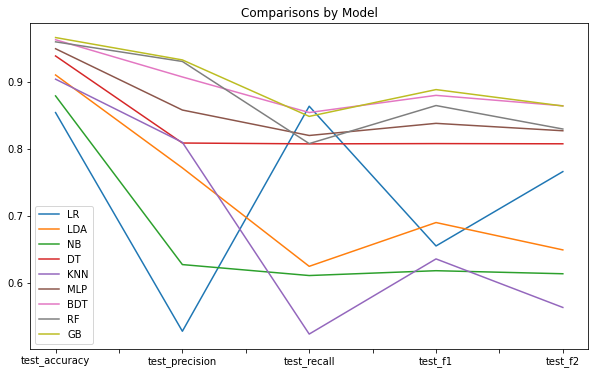

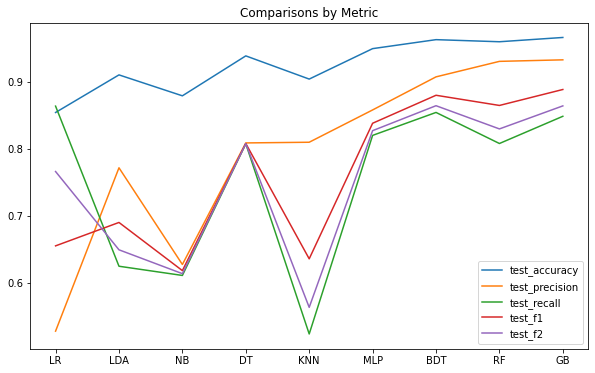

In [37]:
results_trmt_QT_plot = plot_results(results_trmt_QT)

<a id='6.2.4'>
    <h2 style='font-size:180%;'>
        Power Transformer
    </h2>
</a>

In [38]:
results_trmt_PT

LR       LDA        NB        DT       KNN         MLP       \
                mean  std mean  std mean  std mean  std mean  std   mean  std   
fit_time        7.10 4.56 1.09 0.18 1.55 0.33 2.08 0.27 1.56 0.44 107.04 8.23   
score_time      0.03 0.01 0.04 0.01 0.06 0.01 0.06 0.02 2.57 0.46   0.05 0.01   
test_accuracy   0.86 0.01 0.91 0.01 0.88 0.01 0.93 0.01 0.91 0.01   0.95 0.01   
train_accuracy  0.86 0.00 0.91 0.00 0.88 0.00 1.00 0.00 0.93 0.00   1.00 0.00   
test_precision  0.55 0.02 0.79 0.03 0.65 0.04 0.80 0.02 0.84 0.02   0.85 0.02   
train_precision 0.55 0.01 0.79 0.02 0.65 0.02 1.00 0.00 0.91 0.00   1.00 0.00   
test_recall     0.86 0.02 0.64 0.03 0.58 0.03 0.79 0.03 0.54 0.03   0.81 0.02   
train_recall    0.86 0.01 0.64 0.01 0.59 0.01 1.00 0.00 0.65 0.02   1.00 0.00   
test_f1         0.67 0.02 0.71 0.02 0.61 0.02 0.79 0.03 0.66 0.02   0.83 0.02   
train_f1        0.67 0.01 0.71 0.01 0.62 0.01 1.00 0.00 0.76 0.01   1.00 0.00   
test_f2         0.77 0.02 0.67 0.02 0.59 0.02 0.79 0.03 0.58 0.03   0.82 0.02   
train_f2        0.77 0.01 0.67 0.01 0.60 0.01 1.00 0.00 0.69 0.01   1.00 0.00   

                 BDT        RF        GB       
                mean  std mean  std mean  std  
fit_time        8.22 1.23 2.86 0.50 9.75 0.92  
score_time      0.91 1.11 0.29 0.14 0.05 0.01  
test_accuracy   0.96 0.01 0.95 0.01 0.96 0.01  
train_accuracy  1.00 0.00 0.98 0.01 0.97 0.01  
test_precision  0.90 0.01 0.92 0.02 0.92 0.02  
train_precision 1.00 0.00 0.98 0.01 0.94 0.01  
test_recall     0.84 0.03 0.77 0.06 0.83 0.04  
train_recall    1.00 0.00 0.91 0.03 0.87 0.02  
test_f1         0.87 0.02 0.84 0.04 0.88 0.03  
train_f1        1.00 0.00 0.94 0.02 0.91 0.02  
test_f2         0.85 0.03 0.80 0.05 0.85 0.03  
train_f2        1.00 0.00 0.92 0.03 0.88 0.02

In [39]:
results_trmt_PT_plot_df = plot_results_df(results_trmt_PT)

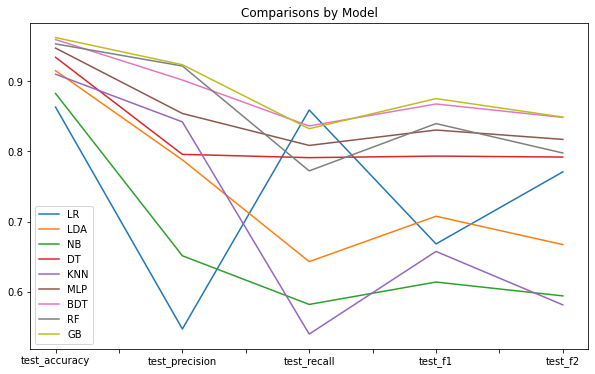

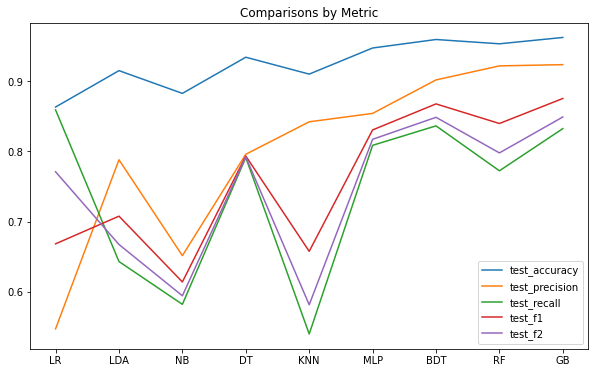

In [40]:
results_trmt_PT_plot = plot_results(results_trmt_PT)

# Comparisons Across Scalers

As expected, linear models such as MLP and LR improved significantly after scaling while the rule-based tree methods are largely unchanged. We will want to experiement with feature selection, resampling, and hyperparameter tuning at a later stage.

In [41]:
def result_by_scaler_one_metric(metric):
    names = ['NS'] + [scalers[i][0] for i in np.arange(len(scalers))]
    dfs = (results_bsl_NS_plot_df, results_trmt_SS_plot_df, results_trmt_MM_plot_df, results_trmt_RS_plot_df, results_trmt_QT_plot_df, results_trmt_PT_plot_df)
    named_dfs = list(zip(names, dfs))
    result=[]
    for i,j in named_dfs:
        filtered = (j.loc[metric,:].rename(i))
        result.append(filtered)
    new_df = pd.concat(result, keys=names, axis=1).T
    return new_df

In [42]:
print('Recall on Test Set')
metric = 'test_recall'
result_by_scaler_one_metric(metric)

Recall on Test Set


,LR,LDA,NB,DT,KNN,MLP,BDT,RF,GB
NS,0.75,0.64,0.62,0.81,0.57,0.45,0.85,0.81,0.85
SS,0.86,0.64,0.60,0.81,0.54,0.80,0.85,0.81,0.85
MM,0.86,0.64,0.60,0.81,0.45,0.78,0.85,0.81,0.85
RS,0.86,0.64,0.60,0.81,0.64,0.82,0.85,0.81,0.85
QT,0.86,0.62,0.61,0.81,0.52,0.82,0.85,0.81,0.85
PT,0.86,0.64,0.58,0.79,0.54,0.81,0.84,0.77,0.83


In [43]:
print('F-2 Score on Test Set')
metric = 'test_f2'
result_by_scaler_one_metric(metric)

F-2 Score on Test Set


,LR,LDA,NB,DT,KNN,MLP,BDT,RF,GB
NS,0.63,0.66,0.63,0.81,0.59,0.46,0.86,0.83,0.86
SS,0.77,0.66,0.62,0.81,0.58,0.80,0.86,0.83,0.86
MM,0.77,0.66,0.62,0.81,0.49,0.80,0.86,0.83,0.86
RS,0.77,0.66,0.62,0.81,0.67,0.83,0.86,0.83,0.86
QT,0.77,0.65,0.61,0.81,0.56,0.83,0.86,0.83,0.86
PT,0.77,0.67,0.59,0.79,0.58,0.82,0.85,0.80,0.85


<a id='6.2.5'>
    <h2 style='font-size:180%;'>
        Run Time Calculation
    </h2>
</a>

In [44]:
print(f'Notebook Total Runtime: {time.strftime("%M:%S", time.gmtime(time.time()-time_start))} min')

Notebook Total Runtime: 27:43 min
